# Solutions: Some Basic Computational Techniques for Optimization

*These are **solutions** to the worksheet on basic computational optimization. Please **DO NOT LOOK AT IT** if you haven't given the worksheet a fair amount of thought.*

In this worksheet we will go over implementing some basic techniques that are widely used for computational optimization in data science and computer science. More specifically, we will look at what are known as *local search* strategies, where we search through some *state space* in order to optimize a given *cost function* (a function that maps states to numbers).

## The Setup

Recall the Approximate Caratheodory Theorem from Vershynin's book:

**Theorem 0.0.2** (Approximate Caratheodory's Theorem)**.** *Consider a set $T \subset \mathbb{R}^n$ whose diameter is bounded by $1$. Then, for every point $x \in \text{conv}(T)$ and every integer $k$, one can find points $x_1,\ldots,x_k \in T$ such that*
$$ \left\lVert x - \frac{1}{k}\sum_{j=1}^k x_j \right\rVert \leq \frac{1}{\sqrt k}$$

In this worksheet we will verify the theorem in the specific case of an $n$-dimensional hypercube, $\{0,1\}^n$. We will computationally find the optimum (minimum) value of the function on the left hand side and verify that it is indeed less than $1/\sqrt{k}$.

## The Problem

Here is a more specific statement of the of the problem we want to solve computationally.
* **Input**: The input is a point $x$ inside the convex hull of the hypercube $\{0,1\}^n$ and an integer $k$.
* **Output**: The output should be a list of $k$ points, each a vertex of the hypercube that minimizes the quantity on the LHS of the inequality from Theorem 0.0.2, as well as the minimum quantity found.

## Preliminaries

Local search techniques rely on three basic objects:
* **States**: These are the entities we are interested in finding the optimal configuration of. In our case, states would be lists of $k$ points, each of them being a vertex of the hypercube $\{0,1\}^n$.
* **The Cost Function**: A function from states to numbers. This is the quantity we want to optimize. In our case the cost function is the quantity on the LHS. We want to minimize this.
* **The Successor Function**: This is a function that maps states to a set of "successor" states. The search algorithm will follow the successor to transition. A good successor function should be able to reach every state from every other state (it should be "connected")

With this in mind, let's get into some coding!

In [8]:
# Some useful imports
import random as rand
import numpy as np
import heapq
import matplotlib.pyplot as plt
import copy
import math
 
# Fill in code where indicated below:

n = 10 # Fill in your favorite dimension
k = 10 # Number of points
x = np.array([rand.random() for i in range(n)]) 
                         # A random (or specific) point in the convex hull.
                         # We recommend using np arrays to represent these,
                         # but it's up to you


# The State Representation

How would we represent a list of $k$ $n$-tuples in Python? One way to do this would be to have a python list of tuples. But we should keep in mind that we might produce many such states, so our representation should be as efficient as possible. One efficient structure that we recommend is a 2D numpy array with rows representing our $n$-tuples. 

In [9]:
# Define a cost function. You may assume that the state is in the representation we recommended above.
# If you had something better in mind, use it.
#
# Parameters: a state and the point x
# Returns: the cost of the state w.r.t. x
def cost(state, x):
    return np.sqrt(np.sum((x - np.sum(state, axis = 0)/k)**2))

In [10]:
# Define a successor function. One successor function we tried using was one which
# returned a set containing all the points from the original state, with one point moved along an edge,
# that is, with one of the points flipped (the coordinates are all 0 or 1)
# Feel free to play around with your own successor function.
#
# Parameters: a state
# Returns: a set/list of states reachable from the given step in one transition
def successors(state):
    successors = []
    for i in range(k):
        for j in range(n):
            succ = copy.deepcopy(state)
            succ[i][j] = 1 if state[i][j]==0 else 0
            successors.append(succ)
    return successors

## Hillclimbing Search

Hillclimbing search is a local search strategy that at each step moves towards the best-looking successor state (optimal cost). When it reaches a state from where every successor has worse cost, it declares victory and returns what it has. Here's the algorithm to make things more precise:

1. Initialize a `current` state, and set it to some valid state.
2. Loop: \
    a. Get all successor states of `current`. \
    b. Check if the best-cost successor state is better than `current`. \
    c. If it is, then set `current` to that state. \
    d. If it isn't, return `current` as the best.

Let us implement hillclimbing search for our example.

In [11]:
# Implement hillclimbing search to find an optimum in our setup.
# Constants n, k, x are defined above.
#
# Returns: the optimal state, the optimal cost value, and a list of the
# costs of best-cost successors encoutered along the search (for plotting)
def hillclimbing():
    history = []
    # Sample an initial state (uniformly now but could be improved)
    current = np.array([[rand.randint(0,1) for j in range(n)] for i in range(k)])
    
    # begin the descent!
    while(True):
        # find the minimum cost neighbor
        neighbor = min(successors(current), key = lambda state: cost(state, x))
        
        # end if we reach a local min
        neighbor_cost = cost(neighbor,x)
        if (neighbor_cost >= cost(current, x)):
            return current, cost(current, x), history
    
        history.append(neighbor_cost)
        current = neighbor

Best :  0.10093681550010632


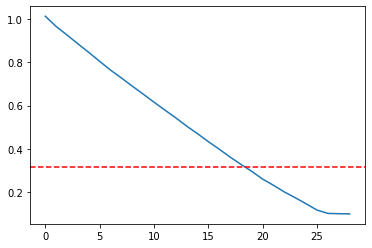

In [13]:
# A quick test and plot
state, finalCost, history = hillclimbing()
print("Best : ", finalCost)

# Plot a graph with the search history as well as a dashed line at 1/sqrt(k)
plt.figure()
plt.plot(history)
plt.axhline(1/math.sqrt(k), color='r', linestyle='dashed')
plt.show()

## Beam Search

Beam Search is another local search strategy which instead of looking at one state at once, it looks at some set number $\beta$ of states (the "beam size"). At each step the successors from these states are examined and the best $l$ are taken. For simplicity we stop searching after some set number of timesteps. The stop condition is something that can be played around with. Stated more formally:

1. Initialize `current` as a list of $\beta$ states.
2. Loop some number of times: \
    a. Loop through each state in `current` and get the successors. \
    b. Choose the $\beta$ best-cost successor states and set them to `current`.

Let us implement beam search.

In [15]:
def beamSearch(beta, numsteps):
    history = []
    # Sample set of beta initial states (uniformly)
    current = [np.array([[rand.randint(0,1) for j in range(n)] for i in range(k)]) for l in range(beta)]

    # begin descent!
    for i in range(numsteps):
        # Get successors of all beta current states
        allSuccessors_unflattened = [successors(state) for state in current]
        
        # flatten the list and remove duplicates (removing duplicates seems annoying...better to just not)
        allSuccessors = [state for states in allSuccessors_unflattened for state in states]

        # get the beta smallest neighbors
        min_neighbors = heapq.nsmallest(beta, allSuccessors, key = lambda state: cost(state, x))

        # add the costs to the fit plot...also super slightly inefficient
        history.append([cost(state, x) for state in min_neighbors])
        current = min_neighbors
        
    # get final best state
    best_state = min(current, key = lambda state: cost(state, x))
    best_fit = cost(best_state, x)
    return best_state, best_fit, history

Best :  0.10093681550010632


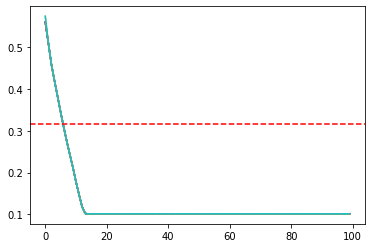

In [18]:
# A quick test and plot
state, best_fit, history = beamSearch(10, 100)
print("Best : ", finalCost)

# Plot a graph
plt.figure()
plt.plot(history)
plt.axhline(1/math.sqrt(k), color='r', linestyle='dashed')
plt.show()

# Things to Think About

Here are some things to think about:
* Does the Approximate Caratheodory bound work?
* Could we use different successor functions and/or modify our search strategy to get better approximations?
* How tight is the $1/\sqrt{k}$ bound guaranteed by the theorem?
* Why is/isn't that bound tight?
* Can we improve this bound for particular point configurations? Another worksheet in this collection walks through the proof of the Approximate Caratheodory Theorem in a particular case to examine this.

# More Things to Do!

## Simulated Annealing

Another technique we could look at is simulated annealing. Simulated annealing is a probabilistic technique for approximating the global optimum of a given function. The name (and technique) is inspired by annealing in metallurgy, a technique involving heating and controlled cooling of a metal. Simulated annealing is similar to hillclimbing, but with the possibility of taking, every once in a while, non-optimal paths with the hope that they end up getting us over a local optimum. The probability of taking non-optimal paths is high when we begin, and reduces as the process goes on according to some time schedule.

If interested, dig into simulated annealing (the [Wikipedia page](https://en.wikipedia.org/wiki/Simulated_annealing#Pseudocode) is a good resource) and implement it here.

**Note:** *This is an incomplete solution and doesn't completely work. However we felt that it might be useful to send out anyway. Feel free to fix it and/or use it as a starting point!*

Best :  0.8432762684223494


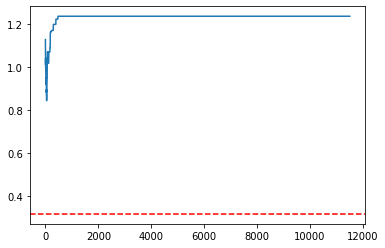

In [17]:
# This is a partial solution and doesn't completely work. Feel free to fix it/go off of it.

swapConst = 0.1 # like Boltzmann constant

temp = 1000
coolRate = 0.01

# cost function for the problem 
# Cost of state w.r.t x
def energy(state):
    # Euclidean distance
    return np.sqrt(np.sum((x - np.sum(state, axis = 0)/k)**2))

def probability(E1, E2, temp):
    return 1.0 if E2 < E1 else math.exp((E1-E2) / temp)


# Return best state and history
def annealing():
    temp = 1000
    coolRate = 0.001
    swapConst = 0.1
    
    # for fit analysis
    fit = []
    # Give a first guess
    current = np.array([[rand.randint(0,1) for j in range(n)] for i in range(k)])
    # Best solution so-far 
    best = current
    while temp > .01:
        neighbor = np.copy(current)

        a = rand.randint(0, k-1)
        b = rand.randint(0, n-1)
        neighbor[a][b] = 1 if neighbor[a][b] == 0 else 1
            
        curr_energy = energy(current)
        neighbor_energy = energy(neighbor)
        # accept on given probability
        if (probability(curr_energy, neighbor_energy, temp) > rand.random()):
            current = neighbor
        
        # Check if this solution is the best so-far
        if (neighbor_energy < energy(best)):
            best = current
            
        fit.append(energy(current))
        temp *= 1 - coolRate
    
    return best, fit

best, fit = annealing()

print("Best : ", energy(best))

# plot the figure
plt.figure()
plt.axhline(1/math.sqrt(k), color='r', linestyle='dashed')
plt.plot(fit)
plt.show()

## Other Optimization Strategies

There are many more optimization strategies used for such problems. Neural nets, genetic algorithms, and stochastic search techniques are some of them. We encourage you to check these out and implement them!